# Install + Imports

In [3]:
!git clone https://github.com/mohammed-elkomy/simple-facial-similarity.git
!pip install imgaug
%matplotlib inline

Cloning into 'simple-facial-similarity'...
remote: Enumerating objects: 452, done.
remote: Counting objects: 100% (452/452), done.
remote: Compressing objects: 100% (450/450), done.
remote: Total 452 (delta 0), reused 449 (delta 0), pack-reused 0
Receiving objects: 100% (452/452), 4.16 MiB | 9.71 MiB/s, done.


In [6]:
import os 
import multiprocessing

import cv2
import matplotlib.pyplot as plt
import numpy as np
import tensorflow as tf
import tensorflow.keras.backend as K
from tensorflow.keras.layers import Flatten, Dense, BatchNormalization, Conv2D, Input, Lambda
from tensorflow.keras.models import Sequential, Model
from tensorflow.keras.optimizers import Adam

os.chdir("simple-facial-similarity")
from facial_dataloader import FacialSequence


/content/simple-facial-similarity/facial_dataloader.py:23: DeprecationWarning: Function `Scale()` is deprecated. Use `Resize` instead. Resize has the exactly same interface as Scale.
  iaa.Scale({"height": 112, "width": 92})


# Model Creation And Training

In [7]:
sister = Sequential()
# input: 112x92 images with 1 channels -> (112, 92, 1) tensors.
# this applies 32 convolution filters of size 3x3 each.
sister.add(Conv2D(4, (3, 3), activation='relu', input_shape=(112, 92, 1), padding="same"))
sister.add(BatchNormalization(axis=-1))  # color space

sister.add(Conv2D(8, (3, 3), activation='relu', padding="same"))
sister.add(BatchNormalization(axis=-1))  # color space

sister.add(Conv2D(16, (3, 3), activation='relu', padding="same"))
sister.add(BatchNormalization(axis=-1))  # color space

sister.add(Flatten())
sister.add(Dense(64, activation='relu'))
sister.add(Dense(8))
sister.add(BatchNormalization(axis=-1))  # normalized euclidean space

sister1_input = Input(shape=(112, 92, 1))
sister2_input = Input(shape=(112, 92, 1))
sister1_output = sister(sister1_input)
sister2_output = sister(sister2_input)


def L2_custom_layer(siamese_outputs):
    _sister1_output, _sister2_output = siamese_outputs
    return K.sum(K.square(_sister1_output - _sister2_output), axis=1, keepdims=True)  # 0 to 8 after normalization


# note that "output_shape" isn't necessary with the TensorFlow backend
l2_squared = Lambda(L2_custom_layer)([sister1_output, sister2_output])  # l2_squared =pow(l2,2)

siamese = Model(inputs=[sister1_input, sister2_input], outputs=l2_squared)


# K.prod( is_same,axis=-1)
def siamese_loss(is_same, _l2_squared):  # 0 same ,1 different
    return (1 - is_same) * _l2_squared + is_same * K.pow(tf.maximum(0.0, margin - K.sqrt(_l2_squared)), 2.0)
    

batch_size = 256
margin = 1.5
epochs = 25
train_enqueuer = FacialSequence(batch_size=batch_size, data_root_path="./data/faces/training")
test_enqueuer = FacialSequence(batch_size=batch_size, data_root_path="./data/faces/testing")
siamese.compile(loss=siamese_loss, optimizer=Adam(lr=10e-6))
siamese.fit_generator(generator=train_enqueuer, steps_per_epoch=40,  # (370 + batch_size - 1) // batch_size,
                      validation_data=test_enqueuer, validation_steps=4,  # (30 + batch_size - 1) // batch_size,
                      epochs=epochs, use_multiprocessing=True, workers=multiprocessing.cpu_count()
                      )

Instructions for updating:
If using Keras pass *_constraint arguments to layers.
Dataset size 370
Dataset size 30
Epoch 1/25
Instructions for updating:
Use tf.where in 2.0, which has the same broadcast rule as np.where
40/40 [==============================] - 49s 1s/step - loss: 2.3533 - val_loss: 0.8201
Epoch 2/25
40/40 [==============================] - 33s 822ms/step - loss: 1.0894 - val_loss: 0.7288
Epoch 3/25
40/40 [==============================] - 33s 835ms/step - loss: 0.8798 - val_loss: 0.7075
Epoch 4/25
40/40 [==============================] - 33s 824ms/step - loss: 0.7488 - val_loss: 0.9690
Epoch 5/25
40/40 [==============================] - 33s 835ms/step - loss: 0.6727 - val_loss: 1.0401
Epoch 6/25
40/40 [==============================] - 33s 833ms/step - loss: 0.6231 - val_loss: 0.6702
Epoch 7/25
40/40 [==============================] - 34s 841ms/step - loss: 0.5675 - val_loss: 0.4724
Epoch 8/25
40/40 [==============================] - 33s 825ms/step - loss: 0.5545 - val_

# Testing

(30, 112, 92, 1)
(30, 112, 92, 1)


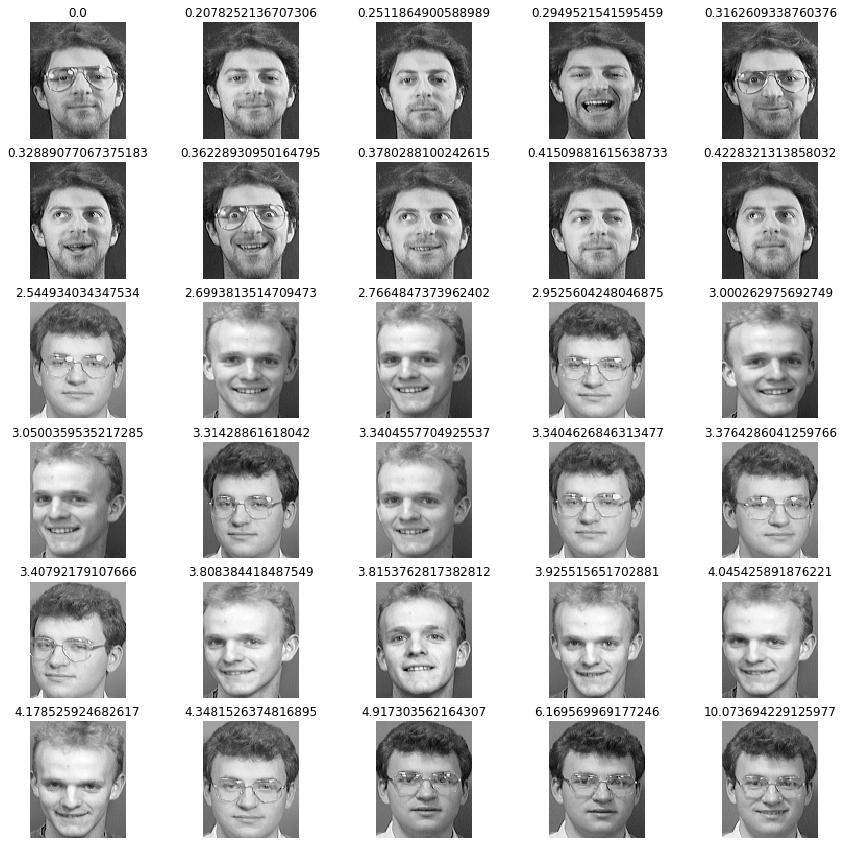

In [10]:
query_image = './data/faces/testing/s7/5.pgm'  # jpg pgm

# preview raw data
def preview_predictions(predictions):
    # 3 channels
    fig, axeslist = plt.subplots(ncols=5, nrows=6, figsize=(15, 15))

    for i, (path, score) in enumerate(predictions):
        axeslist.ravel()[i].imshow(cv2.cvtColor(cv2.imread(path), cv2.COLOR_BGR2GRAY), cmap="gray")
        axeslist.ravel()[i].set_title(score)
        axeslist.ravel()[i].set_axis_off()


#that_images = sorted(list(filter(lambda item: "y" not in item, test_enqueuer.get_data_source())))
that_images = sorted(test_enqueuer.get_data_source())

that_batch = []
for that_image in that_images:
    that_batch.append(cv2.resize(cv2.cvtColor(cv2.imread(that_image), cv2.COLOR_BGR2GRAY), (92, 112)))
that_batch = np.expand_dims(np.array(that_batch), axis=-1).astype(np.float32) / 255.0
print(that_batch.shape)

this_image = np.expand_dims(cv2.resize(cv2.cvtColor(cv2.imread(query_image), cv2.COLOR_BGR2GRAY), (92, 112)), axis=0)
this_batch = np.expand_dims(np.repeat(this_image, len(that_images), axis=0), axis=-1).astype(np.float32) / 255.0
print(this_batch.shape)

query_predictions = sorted(list(zip(that_images, siamese.predict([this_batch, that_batch])[:, 0].tolist())), key=lambda item: item[1])
preview_predictions(query_predictions)
